# Generating relative value trade ideas using PCA

The goal of this exercise is to implement a framework for identifying and analyzing relative value trades using PCA and Python. 

## Setting it up

Let's first import the dependencies we will need. 

In [1]:
%matplotlib inline

import quandl

import numpy as np
from numpy import array
import pandas as pd
from operator import sub
import pickle
import math
import itertools as iter
import datetime as dt
import os
from scipy.misc import comb
import seaborn as sns
import firvtools as firv
import string


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, rc
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, KernelPCA

from IPython.display import display, HTML


rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

print ("Loaded!")

cwd = os.getcwd()
dataDir = cwd+"/depo/Data/"
saveDir = cwd+"/depo/Outputs/"

Loaded!


We will be performing the analysis on swap curves in JPY, EUR, GBP, USD.

For now, let's focus on the EUR Swap Curve.

In [2]:
currencies = ["EUR", "GBP", "JPY", "USD"]
fwd = {}
par = {}

def loadCurrencies(ccylist):
    for ccy in currencies:
        fwd[ccy] = pd.read_pickle(dataDir+"fwd"+ccy)[::-1]
        temp = pd.read_pickle(dataDir+ccy)[::-1]
        if temp.columns.values[0][-1] != "y":
            temp.rename(columns=lambda x: str(x[3:])+"y", inplace=True)
        par[ccy] = temp
        print ("Loaded "+ccy)
    return

def matchTenors(c1, c2):
    assets = list(set(c1.columns.values) & set(c2.columns.values))
    assets.sort(key=lambda x: len(x.split("y")))
    assets.sort(key=lambda x: int(x.split("y")[0]))
    r1 = c1.copy()["assets"]
    r2 = c2.copy()["assets"]
    return r1, r2
    
loadCurrencies(currencies)

Loaded EUR
Loaded GBP
Loaded JPY
Loaded USD


We'll assume that we were doing this analysis in January 2016 so that we can do some OOS analysis later on.

,1y,2y,3y,4y,5y,6y,7y,10y,12y,15y,20y,25y,30y,40y
Dates,,,,,,,,,,,,,,
2016-12-02,-19.9,-15.70,-11.00,-2.45,8.1,20.2,32.8,67.6,85.0,102.85,116.8,120.65,121.9,121.1
2016-12-05,-19.8,-15.45,-8.80,0.10,11.1,23.6,36.6,71.7,89.2,107.10,121.1,124.90,126.1,125.3
2016-12-06,-19.5,-14.30,-6.35,3.02,15.5,28.4,41.6,77.0,94.9,113.10,127.2,131.10,132.3,131.5
2016-12-07,-19.5,-14.80,-8.00,2.23,13.5,26.1,39.1,74.2,91.8,109.80,123.9,127.70,129.0,128.2
2016-12-08,-20.3,-16.29,-9.50,1.68,12.8,25.9,39.6,76.4,95.2,114.30,129.6,134.10,135.9,134.9


,1y,2y,3y,4y,5y,6y,7y,10y,12y,15y,20y,25y,30y,40y
Dates,,,,,,,,,,,,,,
2014-01-01,40.3,53.80,77.05,100.1,125.80,148.30,168.10,215.30,237.30,258.40,271.7,274.20,273.4,273.10
2014-01-02,41.1,52.51,74.70,101.2,126.57,149.15,169.30,217.20,238.65,259.90,273.2,275.80,275.0,275.03
2014-01-03,40.5,51.50,73.60,99.5,125.30,148.15,168.50,216.80,238.65,259.80,273.1,275.80,274.8,275.32
2014-01-06,40.9,52.10,72.50,98.0,122.99,145.55,165.65,213.67,235.50,256.85,270.5,273.40,273.1,273.02
2014-01-07,42.0,52.31,72.70,97.7,122.25,144.50,164.60,212.20,234.30,255.50,269.2,272.15,272.0,272.10


,1y,2y,3y,4y,5y,6y,7y,10y,12y,15y,20y,25y,30y,40y
Dates,,,,,,,,,,,,,,
2016-12-02,-19.9,-15.70,-11.00,-2.45,8.1,20.2,32.8,67.6,85.0,102.85,116.8,120.65,121.9,121.1
2016-12-05,-19.8,-15.45,-8.80,0.10,11.1,23.6,36.6,71.7,89.2,107.10,121.1,124.90,126.1,125.3
2016-12-06,-19.5,-14.30,-6.35,3.02,15.5,28.4,41.6,77.0,94.9,113.10,127.2,131.10,132.3,131.5
2016-12-07,-19.5,-14.80,-8.00,2.23,13.5,26.1,39.1,74.2,91.8,109.80,123.9,127.70,129.0,128.2
2016-12-08,-20.3,-16.29,-9.50,1.68,12.8,25.9,39.6,76.4,95.2,114.30,129.6,134.10,135.9,134.9


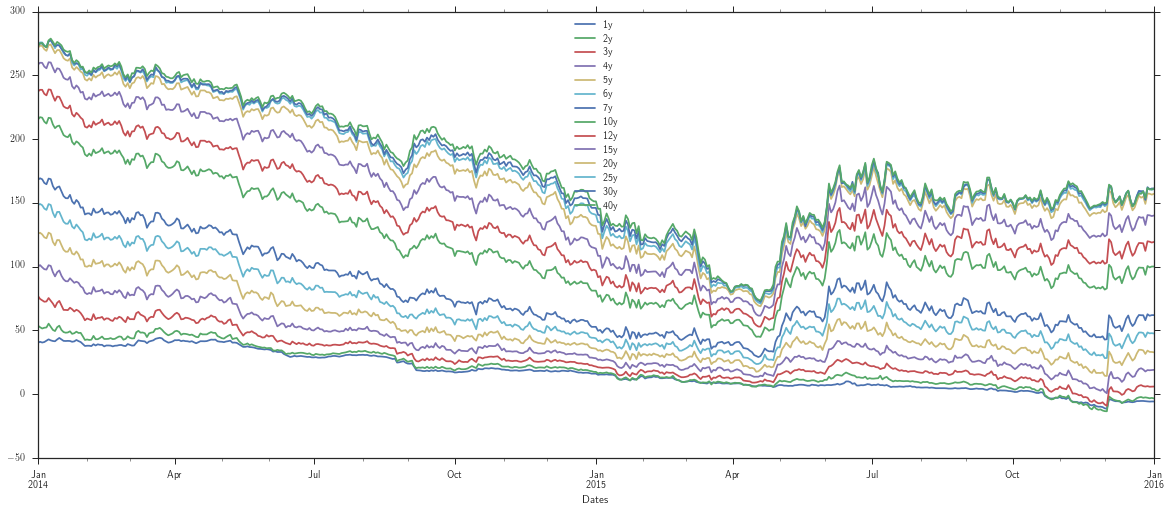

In [3]:

start = dt.datetime(2014, 1, 1)
end = dt.datetime(2016,1, 1)
tenors = ["2y", "5y", "10y", "20y", "30y"]
currency = "EUR"
rawData = par[currency][:] * 100
display(rawData.tail())
assets = rawData.columns.values
data = rawData[start:end]
display(data.head())
sns.set_style("ticks")
rawplot = data.plot(figsize=(20,8))
display(rawData.dropna().tail())

firstDate = data.index[0].strftime("%d %b %y")
lastDate = data.index[-1].strftime("%d %b %y")

## Writing the static PCA function

We'll try to write a function staticPCA. It takes in our raw data, number of components we are interested in (default 4) and resample frequency on the raw data (default 1). It also takes in corrW (default 20), which is used to determine how many periods to use in the rolling correlation of reconstructed factors.

The output of the function will be a dictionary of resultant eigenvalues, eigenvectors, the covariance matrix, and historical reconstructed factors.

Further down the line, we will also need k-factor residuals (residuals found by reconstructing the data using only k-1 factors). We write this helper function and use it in the staticPCA function now, to make things a bit easier.

(Edit: The re-orientation function was written after the fact. Considerable time was spent on automating a way to re-orient the PCs post ante. However, given that yield curve dynamics are understood in that PC1 is level, PC2 slope and PC3 curvature, we can write a reorient function. The reorient function calculates correlations between the level, slope, fly and the individual PCs and re-orients the PCs as they should be. )

In [4]:
def kfacReconstruct(data, evTable, k=3, cols = [], auto= 0):
    ## Auto reorients EVs and PCs
    ## Pick securities to receive data for. If no input, do all. 
    if cols ==[]: 
        cols = data.columns.values
    
    # Returns k-factor reconstruction when given the data and Eigenvectors
    
    result = {}
    
    totFactors = len(evTable.columns.values)
    if totFactors < k:
        print ("Error! Total factors are less than k.")
        return
    
    # get demeaned data
    meanVals = data.mean()
    demeaned = data - meanVals
    
    #reconstruct historical factor time series
    factorTS = demeaned.dot(evTable)
    if auto != 0:
        reOrient = pcReorient(data, factorTS, tol=auto)[:totFactors]
        newEVs = evTable.copy()
        newFactors = factorTS.copy()
        for i in range(totFactors):
            newEVs.loc[:, evTable.columns[i]] *= reOrient[i]
            newFactors.loc[:, factorTS.columns[i]] *= reOrient[i]
        factorTS = newFactors
        evTable = newEVs

    #inverse of eigenvectors
    invEV = pd.DataFrame(np.linalg.pinv(evTable.values), evTable.columns, evTable.index)

    #drop columns to adjust for k factors
    factorTS.drop(factorTS.columns[range(len(factorTS.columns.values))[k:]], axis=1, inplace=True)
    
    #drop rows to adjust for k factors
    invEV.drop(invEV.index[range(len(invEV.index.values))[k:]], axis=0, inplace=True)
    
    #### Reconstruction using k factors
    kRebuild = factorTS.dot(invEV)
    kResiduals = demeaned - kRebuild
    reRaw = kRebuild + meanVals
    
    result["factorTS"] = factorTS
    result["rebuildRaw"] = reRaw[cols]
    result["residuals"] = kResiduals[cols]
    
    return result, evTable
    
def pcReorient(data, factors, tol=2):
    lenData = len(data.columns.values)
    numCurves = lenData//2
    numFlies = comb(lenData, 3)    
    
    pc1corr, pc2corr, pc3corr = 1, 1, 1
        
    if tol > numCurves or tol > numFlies:
        print ("Error.")
        return
    numFactors = len(factors.columns.values)
    if numFactors >=1:
        ## check pc1
        split = lenData//tol
        pc1check = pd.concat([data.ix[:,j*split] for j in range(tol)], axis=1)
        pc1corr = pc1check.corrwith(factors["PC1"]).mean()
    if numFactors >=2:
        ## check pc2
        pc2check = pd.concat([data.ix[:,-i]-data.ix[:,i] for i in range(numCurves)], axis=1)
        pc2corr = pc2check.corrwith(factors["PC2"]).mean()
    if numFactors >=3:
        ## check pc3
        pc3check = data.ix[:,numCurves]*2 - data.ix[:,0] - data.ix[:,-1]
        pc3corr = factors["PC3"].corr(pc3check).mean()
    
    
    return np.sign([pc1corr, pc2corr, pc3corr])

def staticPCA(data, n=3, freq=1, corrW = 12, autoOrient=2, plot=True):
    '''
    This function returns a dictionary with the following key value combinations:
    key    | Value
    raw    | DF with raw data (as resampled)
    covM   | Covariance matrix of raw data
    evals  | n eigenvalues
    evecs  | n eigenvectors
    facTS  | time series of reconstructed factors using raw data. 
    reRaw  | Rebuilt raw data from n EVs, and accompanying residuals
    resid  | Residuals (Actual - Reconstructed)
    facCR  | Rolling cross correlations between factors
    '''
    results = {}
    
    ## resample data based on freq and calc demeaned data
    raw = data.iloc[::freq, :]
    results["rawDat"] = raw
    meanVals = raw.mean()
    demeaned = raw - meanVals
    
    ## Covariance Matrix
    covM = raw.cov()
    results["covM"] = covM
    
    ## PCA
    evals, evecs = np.linalg.eig(covM)
    epairs = [(np.abs(evals[i]), evecs[:,i]) for i in range(len(evals))]
    epairs.sort(key=lambda x: x[0], reverse=True)
    evals = sorted([i*100/sum(evals) for i in evals])[::-1][:n]
    results["evals"] = evals

    evTable = pd.DataFrame(index=covM.index)
    for i in range(n):
        evTable.insert(i, "PC"+str(i+1), epairs[i][1])

    ## Reconstruct
    reConResult = kfacReconstruct(raw, evTable, n, auto=autoOrient)
    reconstructed = reConResult[0]
    evTable = reConResult[1].copy()
    evTable.index = covM.index
    results["evecs"] = evTable
    resid = reconstructed["residuals"]
    facTS = reconstructed["factorTS"]
    reRaw = reconstructed["rebuildRaw"]
    
    results["resid"] = resid
    results["facTS"] = facTS
    results["reRaw"] = reRaw
    

    ## Rolling correlations of factors
    facCR = pd.DataFrame()
    combos =[facTS[list(pair)] for pair in list(iter.combinations(facTS.columns, 2))]
    for df in combos:
        cols = df.columns.values
        facCR["".join(cols)] = facTS[cols[0]].rolling(window=corrW).corr(other=facTS[cols[1]])

    results["facCR"] = facCR
    
    return results




## Playing around with the PCA results

Let's load our GBP curve data into this function and see what we get.

In [5]:
print("Eigenvectors:")
pca1 = staticPCA(data, freq=1, n=1)
pca2 = staticPCA(data, freq=1, n=2)
pca3 = staticPCA(data, freq=1, n=3)
display(pca3["evecs"])
print("Eigenvalues:")
display(pca3["evals"])

Eigenvectors:


,PC1,PC2,PC3
1y,0.091602,-0.280677,-0.468433
2y,0.103324,-0.312904,-0.403306
3y,0.126770,-0.344246,-0.251801
4y,0.156945,-0.361780,-0.073544
5y,0.186655,-0.354202,0.095524
6y,0.214890,-0.321038,0.213109
7y,0.239505,-0.270475,0.282684
10y,0.294796,-0.100316,0.303075
12y,0.319697,-0.003260,0.268920
15y,0.343175,0.109847,0.197349


Eigenvalues:


[97.164061001868419, 2.1007397564130272, 0.68701605256518394]

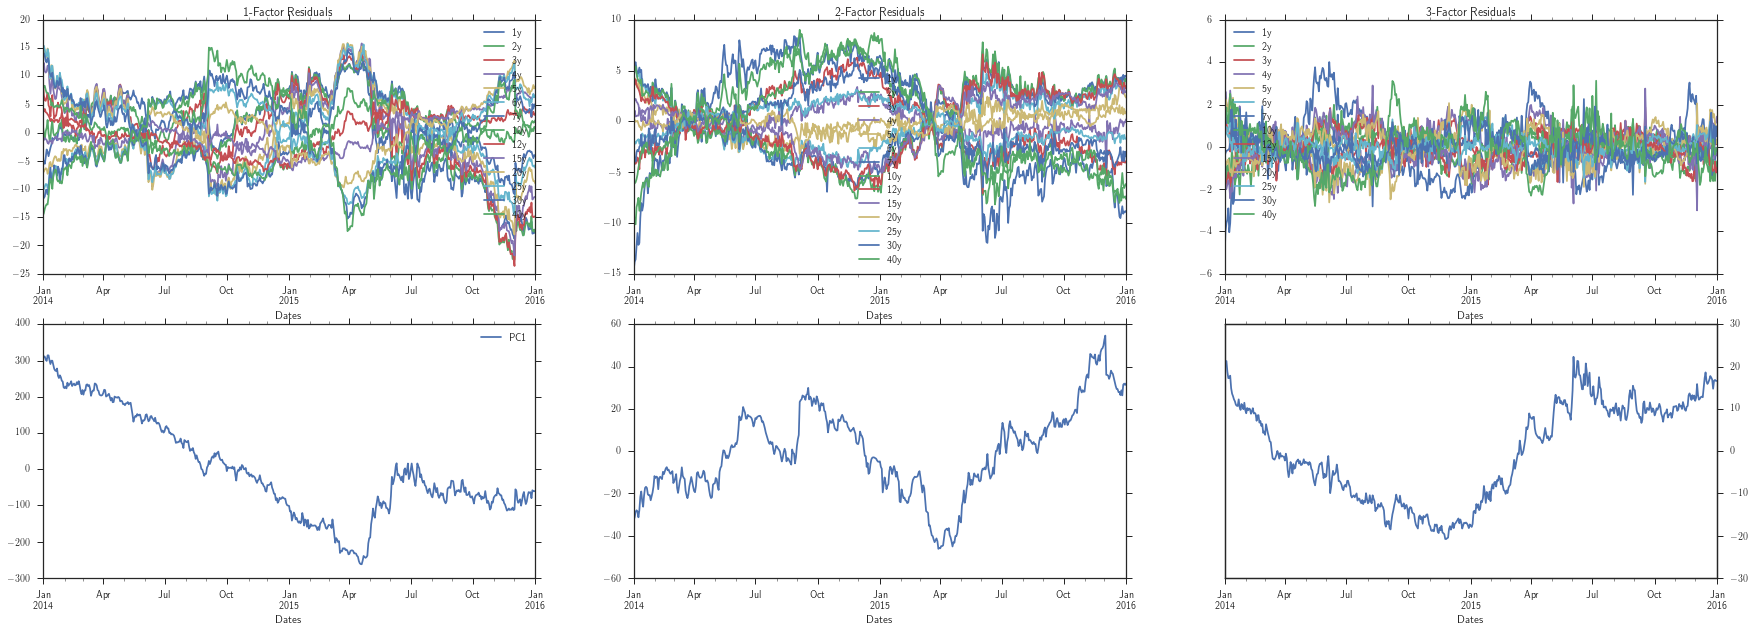

In [6]:
# Plot it.

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(30, 10)
    
pca1["resid"].plot(ax=axes[0, 0], title="1-Factor Residuals")
pca1["facTS"].plot(ax=axes[1, 0])

pca2["resid"].plot(ax=axes[0, 1], title="2-Factor Residuals")
pca2["facTS"]["PC2"].plot(ax=axes[1, 1])

pca3["resid"].plot(ax=axes[0, 2], title="3-Factor Residuals")
pca3["facTS"]["PC3"].plot(ax=axes[1, 2], secondary_y="PC3")


From a cursory glance, it looks like duration is rich, the curve has steepened and flies are fair. We can verify this by plotting the principal components against rates, curve and fly. Should note that the PCs in this case don't look like they mean revert very well during the time period.

                   PC1        PC2        PC3
Dates                                       
2014-01-01  307.650222 -32.629621  19.757295
2014-01-02  311.916863 -31.278539  20.993513
2014-01-03  310.551897 -28.782096  21.319437
2014-01-06  302.493393 -27.973776  18.793665
2014-01-07  299.090253 -28.557472  17.258287


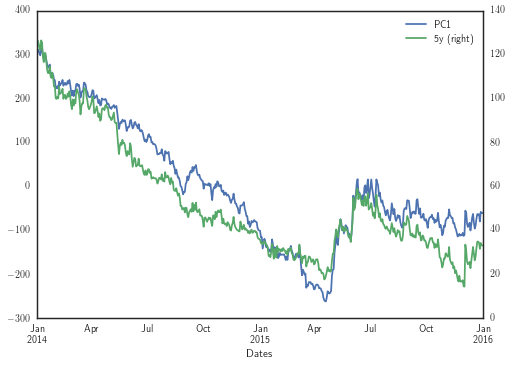

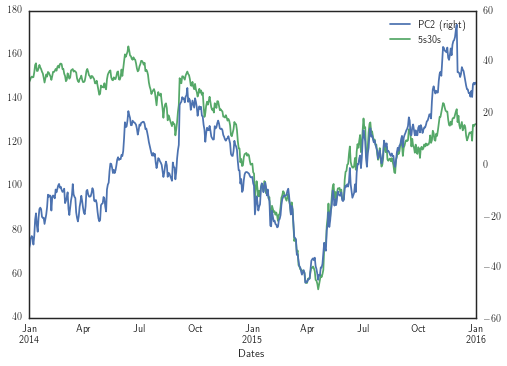

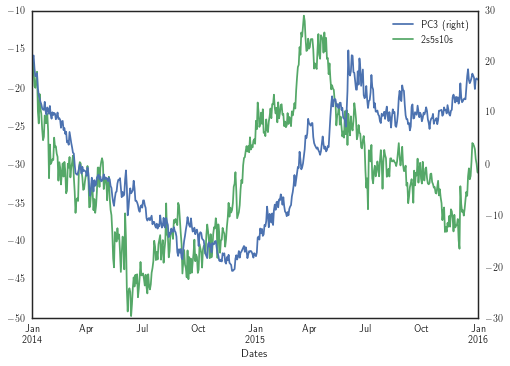

In [45]:


testpc1 = pd.DataFrame()
testpc1["PC1"] = pca3["facTS"]["PC1"].copy()
testpc1["5y"] = data["5y"]
testpc1.plot(secondary_y='5y')

testpc2 = pd.DataFrame()
testpc2["PC2"] = pca3["facTS"]["PC2"].copy()
testpc2["5s30s"] = data["30y"]-data["5y"]
testpc2.plot(secondary_y='PC2')

testpc3 = pd.DataFrame()
print (pca3["facTS"].head())
testpc3["PC3"] = pca3["facTS"]["PC3"].copy()
testpc3["2s5s10s"] = data["5y"]*2-data["2y"]-data["10y"]
testpc3.plot(secondary_y='PC3')

PC3 looks like it mean reverts quite well and is quite low historically. Thus, in looking at the PCA residuals, we will hope to find a fly or curve to receive.

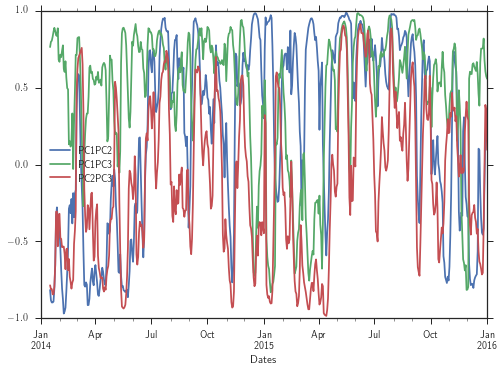

In [8]:
pca3["facCR"].plot()

# Residuals

We create a one page summary of the residuals, which might potentially highlight attractive trades.


            1d         1w         1m        3m
1y  -17.800718 -15.765496 -14.859164 -8.161251
2y  -17.666764 -14.796706 -16.038380 -7.455897
3y  -14.917540 -12.397743 -15.575412 -6.813826
4y  -11.372383  -9.528041 -13.921860 -5.857432
5y   -8.992229  -6.552668 -11.464701 -4.642848
6y   -6.240642  -4.735393  -8.992179 -3.208384
7y   -4.166327  -3.367926  -6.605524 -1.664134
10y   0.796999   0.203121  -0.089220  1.007681
12y   3.375592   2.730601   3.138718  2.310395
15y   6.462189   5.887583   6.809847  4.060310
20y   8.195095   7.367081   9.432872  4.586703
25y   6.496347   5.385320   8.004871  2.750352
30y   4.736860   2.844215   5.895696  1.251295
40y   2.195044   1.806797   3.691465 -0.580012


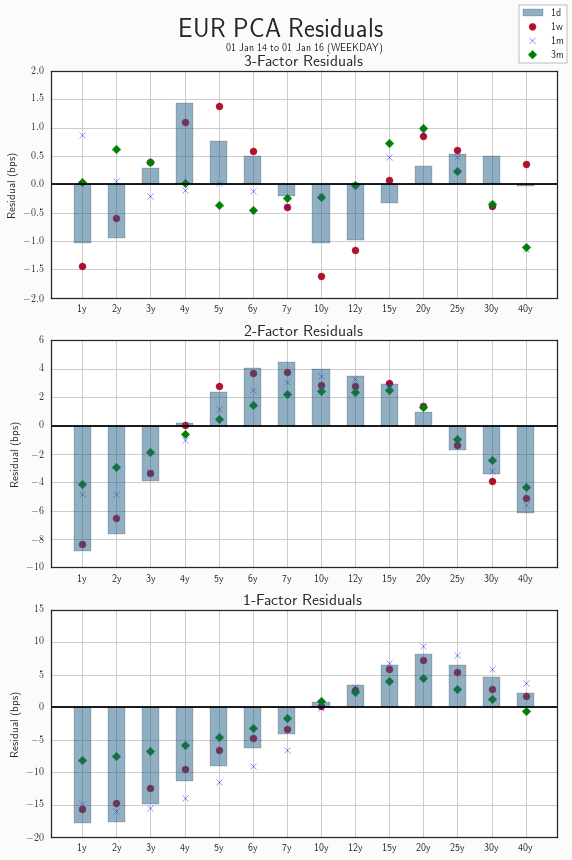

In [9]:
########### Residuals ############
## LEVEL
xvals = range(len(assets))

relVal1 = pd.DataFrame()
relVal1 = pca1["resid"].ix[[-1, -5, -20, -60]]
relVal1.index = ["1d", "1w", "1m", "3m"]
relVal1 = relVal1.transpose()
print (relVal1)

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(8, 12), dpi=400, facecolor="#fbfbfb")
fig.suptitle("%s PCA Residuals"%currency, fontsize=26)

### 1-Factor PCA residual 
ax1 = plt.subplot2grid((3, 1), (2, 0), colspan=1)
xvals = range(len(assets))
lday=ax1.bar(xvals, relVal1["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax1.set_xticks(xvals)
ax1.set_xticklabels(assets)
plt.grid()
s = 25
lwk= ax1.scatter(xvals, relVal1["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
lmnth=ax1.scatter(xvals, relVal1["1m"], color='b', marker = "x", s=1.5*s, label="1m")
lquart=ax1.scatter(xvals, relVal1["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax1.axhline(0, color="black")
ax1.set_title("1-Factor Residuals", fontsize="16")
#ax1.set_axis_bgcolor('#f8fcff')
ax1.set_ylabel("Residual (bps)")

## 2-Factor PCA residual

relVal2 = pd.DataFrame()
relVal2 = pca2["resid"].ix[[-1, -5, -20, -60]]
relVal2.index = ["1d", "1w", "1m", "3m"]
relVal2 = relVal2.transpose()

ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=1)
ax2.bar(xvals, relVal2["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax2.set_xticks(xvals)
ax2.set_xticklabels(assets)
plt.grid()
s = 25
ax2.scatter(xvals, relVal2["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
ax2.scatter(xvals, relVal2["1m"], color='b', marker = "x", s=1.5*s, label="1m")
ax2.scatter(xvals, relVal2["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax2.axhline(0, color="black")
ax2.set_title("2-Factor Residuals", fontsize="16")
#ax2.set_axis_bgcolor('#f8fcff')
ax2.set_ylabel("Residual (bps)")

## 3-Factor PCA residual


relVal3 = pd.DataFrame()
relVal3 = pca3["resid"].ix[[-1, -5, -20, -60]]
relVal3.index = ["1d", "1w", "1m", "3m"]
relVal3 = relVal3.transpose()

ax3 = plt.subplot2grid((3, 1), (0, 0), colspan=1)
ax3.bar(xvals, relVal3["1d"], alpha=0.5,color='#256189', align='center', width=0.5, label='1d')
ax3.set_xticks(xvals)
ax3.set_xticklabels(assets)
plt.grid()
s = 25
ax3.scatter(xvals, relVal3["1w"], color='#B20F2C', marker = "o", s=2*s, label='1w')
ax3.scatter(xvals, relVal3["1m"], color='b', marker = "x", s=1.5*s, label="1m")
ax3.scatter(xvals, relVal3["3m"], color='g', marker = "D", s=1.5*s, label="3m")
ax3.axhline(0, color="black")
ax3.set_title("3-Factor Residuals", fontsize="16")
#ax3.set_axis_bgcolor('#f8fcff')
ax3.set_ylabel("Residual (bps)")

freq = firv.freqRules[pd.infer_freq(data.index)]
plt.text(0.5, 1.1,'%s to %s (%s)'%(firstDate, lastDate, freq), ha='center', va='center', transform=ax3.transAxes, fontsize=10)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.figlegend([lday, lwk, lmnth, lquart], ["1d", "1w", "1m", "3m"], frameon=True,loc="upper right" )

plt.savefig("%s/depo/%s-PCA Residuals - %s %s"%(cwd, currency, lastDate, freq))

# Rolling PCA

Here we try to implement a rolling PCA in order to study the stability of eigenvectors and eigenvalues over time.


In [10]:
def rollingPCA(data, lb=30, n=3, corrW=12, skip=1, autoOrient=2):
    """
    For now, this function returns a data frame with time series of eigenvalues and eigenvectors of a rolling PCA. 
    """

    rollResult = {}
    
    assets = data.columns.values
    pcCols = ["PC"+str(i+1) for i in range(n)]
    eVecCols = [pc+asset for pc in pcCols for asset in assets]
    
    # Create dataframe for results. 
    accumEvals = pd.DataFrame(columns = range(1, n+1), index=data.index.values[lb:])
    accumEvecs = dict.fromkeys(pcCols, pd.DataFrame(columns=assets, index=data.index.values[lb:]))
    alleVectors = pd.DataFrame(index=data.index.values[lb:], columns = eVecCols)
    
    ### Rolling PCA - Loop and save data.
    
    for i in range(0, len(data.index)-lb, skip):
        
        temp = data[i:lb+i]
        currDate = data.index.values[lb+i]
        res = staticPCA(temp, n=n, corrW=corrW, autoOrient = autoOrient)

        ## Save eigenvalues
        eigenvalues = res["evals"]
        for j in range(len(eigenvalues)):
            accumEvals.set_value(currDate,j+1,eigenvalues[j])

        ## Save eigenvectors
        eigenvectors = res["evecs"]
        tempDict = {}
        for pc in pcCols:
            factor = eigenvectors[pc]
            #print (i, pc, factor.tolist())
            for k in range(len(assets)):
                alleVectors.set_value(currDate, pc+assets[k], factor[k])
    
    #### Split data into PC1, PC2, PC3 and drop NAs.
    
    accumEvals = accumEvals.dropna()

    grouped = alleVectors.groupby(lambda x: x[:3], axis=1)
    
    for pc in pcCols:
        accumEvecs[pc] = grouped.get_group(pc).dropna()
        accumEvecs[pc].rename(columns=lambda x: x[3:], inplace=True)
    accumEvals.columns = pcCols
    rollResult["evectors"] = accumEvecs
    rollResult["evalues"] = accumEvals
    
    ## Secret
    rollResult["master"] = alleVectors.dropna()
    
    return rollResult
            
#pcaResults = rollingPCA(rawData[:data.index.values[0]].dropna(), lb=252, skip=30, autoOrient=3)
pcaResults = rollingPCA(data, lb=30, autoOrient=2)
print ("Done!")


Done!


Let's see what the eigenvalues and eigenvectors look like over time. Their stability would highlight the effectiveness of the PCA based model for this particular set of data.

Eigenvalues:


,PC1,PC2,PC3
2015-12-28,92.7069,6.06377,0.693189
2015-12-29,92.8337,5.99909,0.607088
2015-12-30,93.5861,5.41275,0.47765
2015-12-31,93.8896,5.22357,0.412241
2016-01-01,94.049,5.12209,0.374282


####### PC1 historical ########
                   1y        2y        3y        4y        5y        6y  \
2015-12-28    0.08633  0.174578  0.233511  0.275383  0.319714  0.323801   
2015-12-29  0.0866239  0.177372  0.237736  0.279954  0.323836  0.327087   
2015-12-30  0.0830412  0.172755  0.233891   0.27634  0.320168  0.324479   
2015-12-31  0.0813509  0.170124  0.231637  0.275118  0.317709  0.323147   
2016-01-01  0.0817725  0.170241  0.231945   0.27599  0.316841  0.323083   

                  7y       10y       12y       15y       20y       25y  \
2015-12-28  0.322268  0.316252  0.310783  0.298235  0.270637   0.25084   
2015-12-29  0.324378  0.315222  0.308848  0.295905  0.267219  0.246382   
2015-12-30  0.322573   0.31401  0.308467  0.296927   0.27021  0.251272   
2015-12-31  0.320771  0.312205  0.308307  0.297932  0.272466    0.2549   
2016-01-01   0.32053  0.311426  0.306249  0.296786  0.271492  0.255017   

                 30y       40y  
2015-12-28  0.234747  0.209688  
2015-1

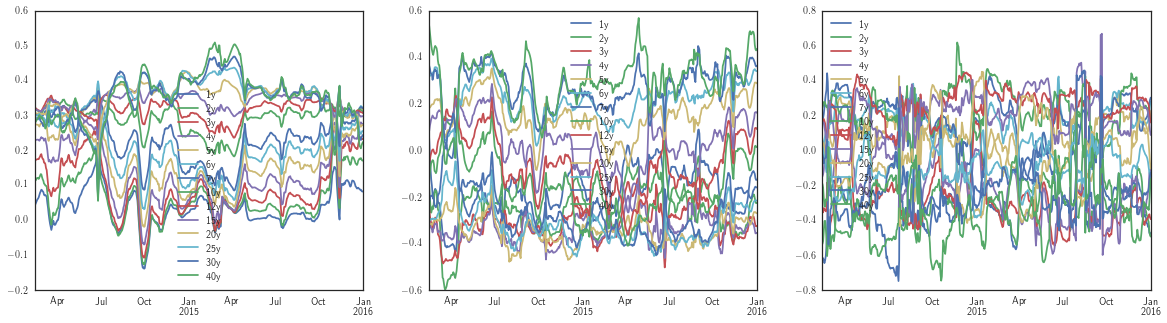

In [11]:

print ("Eigenvalues:")
display(pcaResults["evalues"].tail())
print ("####### PC1 historical ########")
print (pcaResults["evectors"]["PC1"].tail())
print ("####### PC2 historical ########")
print (pcaResults["evectors"]["PC2"].tail())
print ("####### PC3 historical ########")
print (pcaResults["evectors"]["PC3"].tail())

pc1raw = pcaResults["evectors"]["PC1"]
pc2raw = pcaResults["evectors"]["PC2"]
pc3raw = pcaResults["evectors"]["PC3"]

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 5)

pc1raw.plot(ax=axes[0])
pc2raw.plot(ax=axes[1])
pc3raw.plot(ax=axes[2])


Wait, what? 

Ok, so this is because the static PCAs that are being run sometimes will generate eigenvectors that are in the opposite orientation of the previous eigenvector. But this isn't really a point to worry about. Eigenvectors would be equivalent to their negatives. What we can do, however, is to try our best to flip the eigenvectors to the direction that makes sense. 

The following function tries to achieve this task. It is not perfect, but it does not affect the purposes of the exercise (which is to determine the stability of the EVs). The stability is discernible well enough with the smoothing applied.

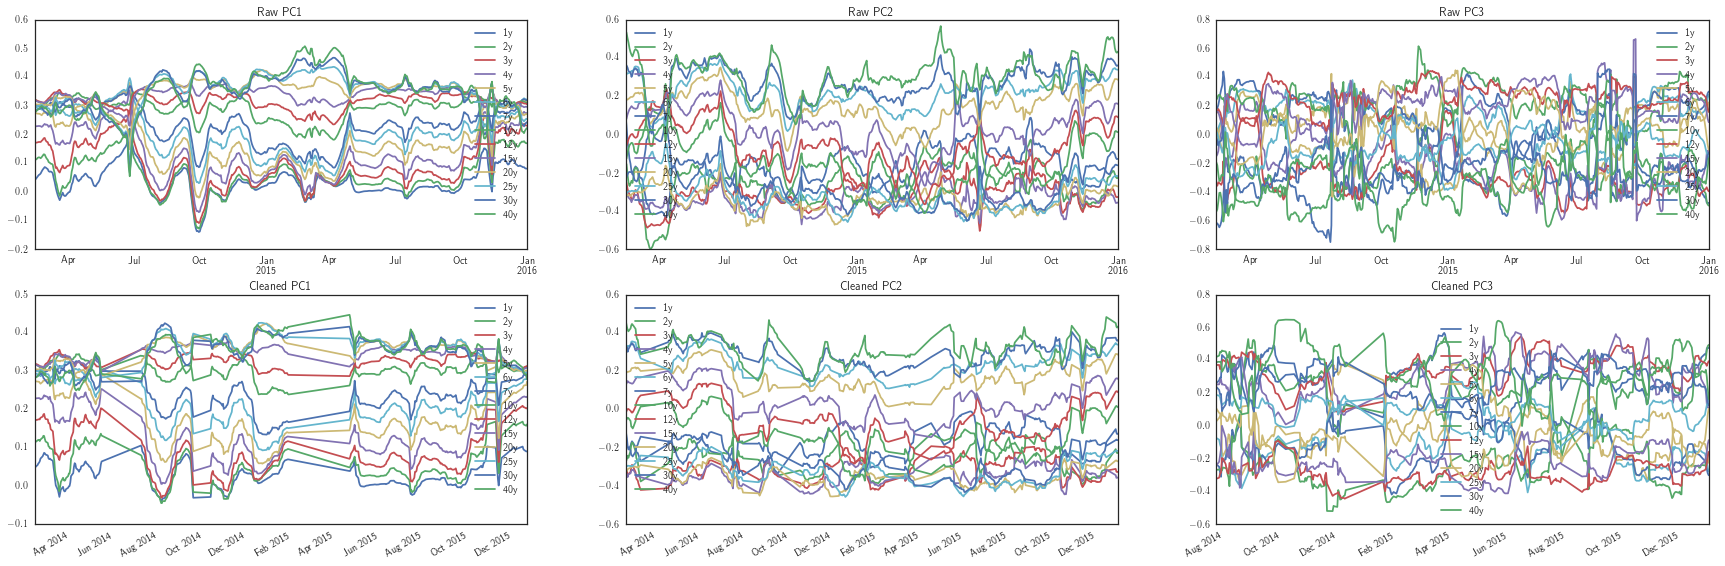

In [12]:

def cleanPCs(input, smoothing=1):
    newdf = pd.DataFrame(index=input.index.values, columns=input.columns.values)
    flag = "flipped"

    for i in range(1, len(input)):
        if i ==1:
            prevfactor = input.iloc[i-1]
        else:
            prevfactor = newdf.iloc[i-1]
        factor = input.iloc[i]
        negfactor = [-i for i in factor.tolist()]

        orig = sum([np.abs(x) for x in (factor-prevfactor).tolist()])
        new = sum([np.abs(x) for x in (-factor-prevfactor).tolist()])
        
        if orig > new:
            for s in range(len(input.columns.values)):
                newdf.set_value(newdf.index.values[i], newdf.columns.values[s], -1*input.iloc[i, s])
                flag = "flipped"
        else:
            for s in range(len(input.columns.values)):
                newdf.set_value(newdf.index.values[i], newdf.columns.values[s], input.iloc[i, s])
                flag = "same"
    
    if smoothing==1:
        newdf = newdf[newdf.apply(lambda x: np.abs(x - x.mean()) / x.std() < 2).all(axis=1)]
        newdf = newdf[newdf.apply(lambda x: np.abs(x - x.mean()) / x.std() < 2).all(axis=1)]

        
    return newdf
            

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(30, 10)
    
pc1raw.plot(ax=axes[0, 0], title="Raw PC1")
cleanPCs(pc1raw).plot(ax=axes[1, 0], title="Cleaned PC1")

pc2raw.plot(ax=axes[0, 1], title="Raw PC2")
cleanPCs(pc2raw).plot(ax=axes[1, 1], title="Cleaned PC2")

pc3raw.plot(ax=axes[0, 2], title="Raw PC3")
cleanPCs(pc3raw).plot(ax=axes[1, 2], title="Cleaned PC3")

A bit better...

What about the Eigenvalues?

                PC11y     PC12y     PC13y     PC14y     PC15y     PC16y  \
2014-02-12  0.0407974   0.11376  0.175405  0.230661  0.276792  0.297259   
2014-02-13  0.0446543  0.112744  0.171835  0.230106  0.274928  0.295315   
2014-02-14  0.0494372  0.114842  0.172348  0.229289  0.274106  0.294091   
2014-02-17  0.0548201  0.119102  0.173451  0.230013  0.273352  0.292778   
2014-02-18   0.058861  0.120805  0.174396  0.230338  0.273062  0.292203   

               PC17y    PC110y    PC112y    PC115y    ...           PC35y  \
2014-02-12  0.305169  0.321511  0.321643  0.318315    ...      -0.0382279   
2014-02-13   0.30369  0.320698  0.320939  0.318223    ...      -0.0241515   
2014-02-14  0.302132  0.318224  0.319832  0.316978    ...    -0.000628537   
2014-02-17  0.300548  0.315522  0.317793  0.315523    ...       0.0312029   
2014-02-18  0.299832  0.313703  0.316599  0.314363    ...       0.0678735   

                 PC36y     PC37y    PC310y    PC312y    PC315y      PC320y  \
2014-02-

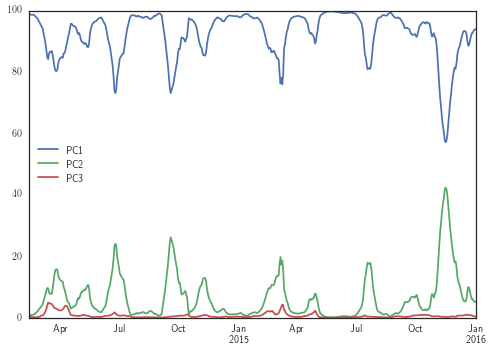

In [13]:
pcaResults["evalues"].plot()
print (pcaResults["master"].head())

Not too bad. 

# Snapshots over time

Alternatively, we can look at a snapshot of the eigenvectors and values at different points in time. This will hopefully provide a bit more insight than the previous rolling PCA charts which were quite noisy. This function will generate a subset of the rolling PCA results, showing only snapshots on an input set of dates and a lookback period on the rolling PCA.

In [14]:
"""
NEEED TO REWRITE 


lb = 250
lastDate = data.index.values[0]
lastIndex = list(rawData.index.values).index(lastDate)
testDates = [data.index.values[i] for i in range(lb, len(data.index.values), 250)]

target = pd.DataFrame(index=testDates)
print (testDates)

orig = pcaResults["master"]

result = target.join(orig)
#print (result)

def pcaSnapshot(dates, data, lb=30, n=3,orient=True, tol=1.5):
    # Returns tuple of evalues and a dict of evectors.
    reorient = len(dates)*[1]
    
    pcaResults = rollingPCA(data, lb=lb, n=n)
    orig = pcaResults["master"]
    evectors = pd.DataFrame(index=dates).join(orig)
    
    evalues = pd.DataFrame(index=dates).join(pcaResults["evalues"])

    pcCols = evalues.columns.values
    
    grouped = evectors.groupby(lambda x: x[:3], axis=1)
    
    accumEvecs = dict.fromkeys(pcCols, pd.DataFrame(columns=data.columns.values, index=data.index.values[lb:]))
    flag = 0
    for pc in pcCols:
        if flag == 0 and orient :
            flag = 1
            temp = grouped.get_group(pc).dropna()
            temp['orient'] = temp.applymap(np.sign).sum(axis=1)
            reorient = temp["orient"].apply(lambda x: (-1)**((np.abs(x-temp["orient"].mean())/temp["orient"].std()<tol)-1))
        
        factors = grouped.get_group(pc).dropna()
            
        accumEvecs[pc] = factors.mul(reorient, axis=0)
        accumEvecs[pc].rename(columns=lambda x: x[3:], inplace=True)
    
    return evalues, accumEvecs

testSnap = pcaSnapshot(testDates, rawData.dropna(), orient=True, tol=1.5)

print ("Done")

"""

'\nNEEED TO REWRITE \n\n\nlb = 250\nlastDate = data.index.values[0]\nlastIndex = list(rawData.index.values).index(lastDate)\ntestDates = [data.index.values[i] for i in range(lb, len(data.index.values), 250)]\n\ntarget = pd.DataFrame(index=testDates)\nprint (testDates)\n\norig = pcaResults["master"]\n\nresult = target.join(orig)\n#print (result)\n\ndef pcaSnapshot(dates, data, lb=30, n=3,orient=True, tol=1.5):\n    # Returns tuple of evalues and a dict of evectors.\n    reorient = len(dates)*[1]\n    \n    pcaResults = rollingPCA(data, lb=lb, n=n)\n    orig = pcaResults["master"]\n    evectors = pd.DataFrame(index=dates).join(orig)\n    \n    evalues = pd.DataFrame(index=dates).join(pcaResults["evalues"])\n\n    pcCols = evalues.columns.values\n    \n    grouped = evectors.groupby(lambda x: x[:3], axis=1)\n    \n    accumEvecs = dict.fromkeys(pcCols, pd.DataFrame(columns=data.columns.values, index=data.index.values[lb:]))\n    flag = 0\n    for pc in pcCols:\n        if flag == 0 and or

Let's display the results.

In [15]:
"""
NEED TO REWRITE
evalues = testSnap[0]
evectors = testSnap[1]

## Eigenvalues
display(evalues)
dateStrings = [pd.to_datetime(str(date)).strftime("%b %Y") for date in evalues.index.values]
ax = evalues.transpose().plot(kind="bar", title="Eigenvalues over time", colormap="YlGnBu", grid=True)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, dateStrings, loc="best")
ax.set_axis_bgcolor("#f8fcff")

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(20, 5)


for i in range(len(evectors.keys())):
    ax = evectors["PC"+str(i+1)].transpose().plot(ax=axes[i], kind="bar", legend=False, colormap="YlGnBu", grid=True)
    lines, labels = ax.get_legend_handles_labels()
    ax.set_axis_bgcolor('#f8fcff')
    ax.set_title("PC"+str(i+1))
    #ax.legend(lines, dateStrings, loc="best")

fig.suptitle("Eigenvectors over time", fontsize="26")
fig.tight_layout()
fig.subplots_adjust(top=0.8)
plt.figlegend(lines, dateStrings, frameon=True,loc="upper right", ncol=len(dateStrings))

"""


'\nNEED TO REWRITE\nevalues = testSnap[0]\nevectors = testSnap[1]\n\n## Eigenvalues\ndisplay(evalues)\ndateStrings = [pd.to_datetime(str(date)).strftime("%b %Y") for date in evalues.index.values]\nax = evalues.transpose().plot(kind="bar", title="Eigenvalues over time", colormap="YlGnBu", grid=True)\nlines, labels = ax.get_legend_handles_labels()\nax.legend(lines, dateStrings, loc="best")\nax.set_axis_bgcolor("#f8fcff")\n\nfig, axes = plt.subplots(nrows=1, ncols=3)\nfig.set_size_inches(20, 5)\n\n\nfor i in range(len(evectors.keys())):\n    ax = evectors["PC"+str(i+1)].transpose().plot(ax=axes[i], kind="bar", legend=False, colormap="YlGnBu", grid=True)\n    lines, labels = ax.get_legend_handles_labels()\n    ax.set_axis_bgcolor(\'#f8fcff\')\n    ax.set_title("PC"+str(i+1))\n    #ax.legend(lines, dateStrings, loc="best")\n\nfig.suptitle("Eigenvectors over time", fontsize="26")\nfig.tight_layout()\nfig.subplots_adjust(top=0.8)\nplt.figlegend(lines, dateStrings, frameon=True,loc="upper righ

Not too bad.

# Generating weights for curve and fly trades

The next thing to do is create a function that would generate trades that are PC hedged. 

In [16]:
def getWgts(trade, evectors,bpvs=0):
    ### Returns risk to use in trades
    eVec = evectors.copy()
    if "-" in trade:
        tenors = trade.split("-")
        
    else:
        tenors = sorted([int(x.strip()) for x in trade.split("s") if x])
        tenors = [str(i)+"y" for i in tenors]
        ## re-index evectors:
        newIndex = [''.join(i for i in x if i.isdigit())+"y" for x in evectors.index.values]
        eVec.index = newIndex

    if len(tenors)==2:
        short = tenors[0]
        long = tenors[1]
        es = evectors.at[short, "PC1"]
        el = evectors.at[long, "PC1"]
        return [-el/es, 1]
        
    
    if len(tenors)==3:
        belly = tenors[1]
        wings = [w for w in tenors if w not in belly]
        wingFactors = pd.DataFrame(index=wings)
        wingFactors = wingFactors.join(eVec).ix[:,:-1].transpose()
        bellyFactor = pd.DataFrame(index=[belly])
        bellyFactor = bellyFactor.join(eVec).ix[:,:-1].transpose()
        invcoeff = np.linalg.pinv(wingFactors)
        bellyFactor.loc[:] *= -1
        rhs = invcoeff.dot(bellyFactor)
        rhs = [2*x for x in list(np.ravel(rhs))]
        rhs.insert(1, 2)
        
        return rhs
    else:
        print("Oops. Not enough, or too many instruments.")
    return

        

Let's look at receiving 2s5s10s and 15s20s (based on the residuals above). Testing it here:

In [86]:
#curve = "25y5y-30y10y"
fly = "2s5s10s"
#longfly = "12y3y-15y5y-20y5y"
curve = "10s20s"
#fly = "2s5s7s"
#longfly = "4s5s6s"
evectors = (pca3["evecs"])
#print (evectors)

pv01s = firv.pv01d
#print (getWgts(curve, pca3["evecs"]))
print (getWgts(fly, pca3["evecs"]))
print (getWgts(curve, pca3["evecs"]))

#print (getWgts(longfly, pca3["evecs"]))

[-2.093187067189151, 2, -0.53268534639125764]
[-1.197399277980508, 1]


We are going to need a function to generate the time series for weighted flies. 

19.285714148
0.714881153487977
37.2403322742
29.99956272578539


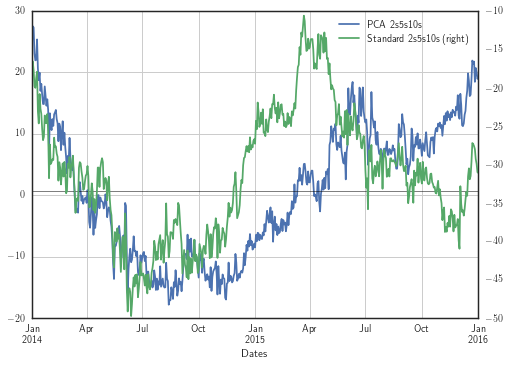

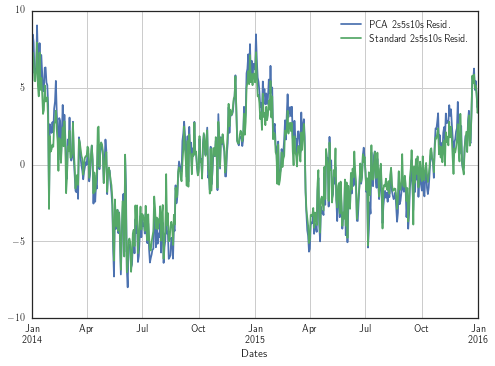

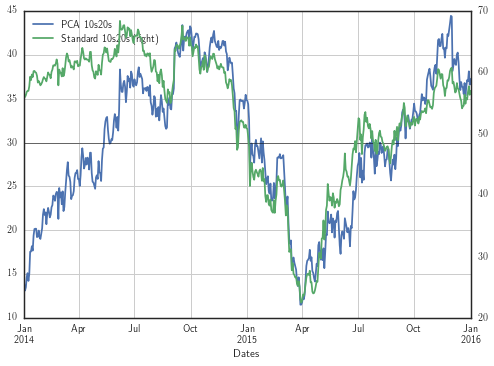

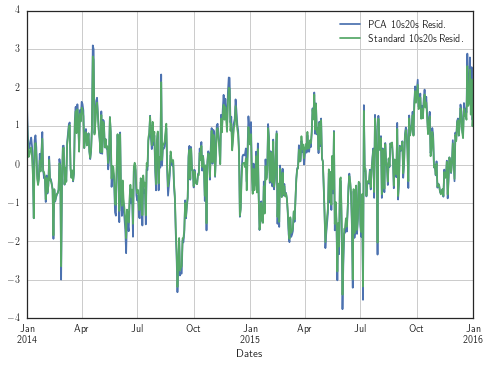

In [87]:
def genTrade(trade, data, pcaResult):
    eVec = pcaResult["evecs"].copy()
    
    
    if "-" in trade:
        tenors = trade.split("-")
        
    else:
        tenors = sorted([int(x.strip()) for x in trade.split("s") if x])
        tenors = [str(i)+"y" for i in tenors]
        ## re-index evectors:
        newIndex = [''.join(i for i in x if i.isdigit())+"y" for x in eVec.index.values]
        eVec.index = newIndex
        
    pcaWgts = getWgts(trade, eVec)
    
    result = data[tenors].copy()
    result["PCA "+trade] = result.dot(pcaWgts)
    
    if len(tenors) == 2:
        result["Standard "+trade] = result[tenors[1]] - result[tenors[0]]
    elif len(tenors)==3:
        legs = data[tenors].copy()
        result["Standard "+trade] = legs.dot(np.array([-1, 2, -1]))
    
    residuals = pcaResult["resid"][tenors].copy()
    residuals["PCA "+trade+" Resid."] = residuals.dot(pcaWgts)
    if len(tenors) == 2:
        residuals["Standard "+trade+" Resid."] = residuals[tenors[1]] - residuals[tenors[0]]
    elif len(tenors)==3:
        rlegs = residuals[tenors].copy()
        residuals["Standard "+trade+" Resid."] = rlegs.dot(np.array([-1, 2, -1]))    
    
    
    return result, residuals

#### 3s6s10s FLY #####
flyTrade, flyResiduals = genTrade(fly, data, pca3)
fmean = flyTrade["PCA "+fly].mean()
print (flyTrade["PCA "+fly][-1])
print (fmean)
ax1 = flyTrade.ix[:, 3:].plot(secondary_y="Standard "+fly, grid=True)
ax1.axhline(fmean, color="black", linewidth=0.5)
flyResiduals.ix[:, 3:].plot(grid=True)


### 15s20s CURVE ###
curveTrade, curveResiduals = genTrade(curve, data, pca3)
cmean = curveTrade["PCA "+curve].mean()
print (curveTrade["PCA "+curve][-1])
print (cmean)
ax2 = curveTrade.ix[:, 2:].plot(secondary_y="Standard "+curve, grid=True)
ax2.axhline(cmean, color="black", linewidth=0.5)
curveResiduals.ix[:, 2:].plot(grid=True)


The fly looks to mean revert quite well. We will test this a bit later.

It might be interesting to see what the PCA hedge really means visually by regressing vs. actual movements in the principal components. 

The residuals above point to receiving 2s5s10s. Let's model this trade. 

In [88]:
histFactors = pca3["facTS"]
residuals = pca3["resid"]
diffFactors = histFactors.diff()
#display(histFactors.tail())
#display(diffFactors.tail())
curves = curveTrade.ix[:, 2:]
curvesChg = curves.diff()
flies = flyTrade.ix[:, 3:]
fliesChg = flies.diff()
#display(curves.tail())
#display(curvesChg.tail())
#display(flies.tail())
#display(fliesChg.tail())

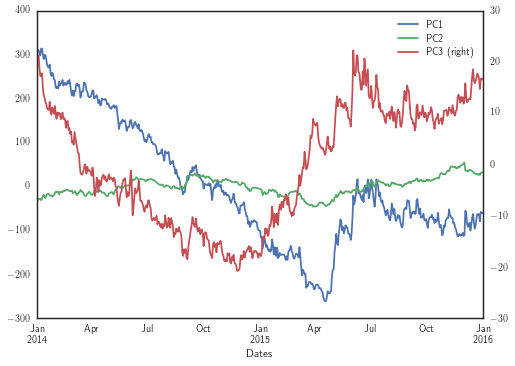

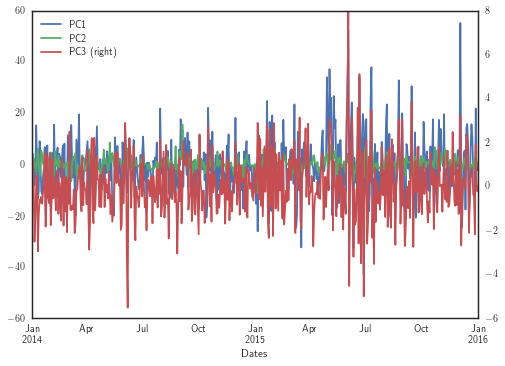

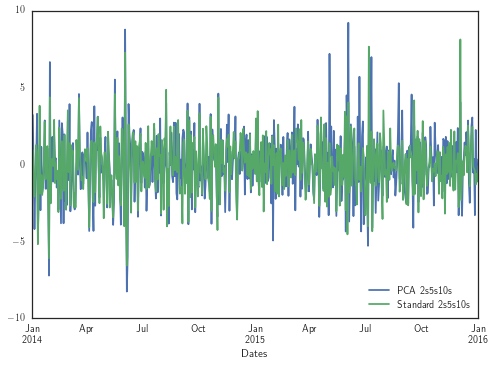

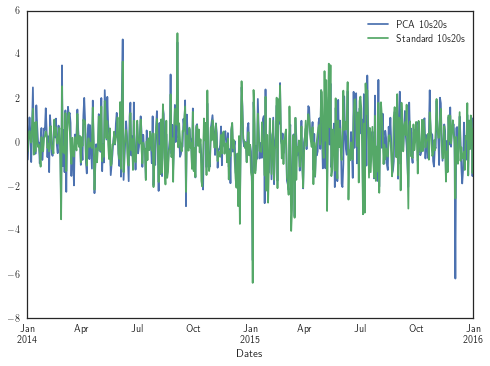

In [89]:
histFactors.plot(secondary_y="PC3")
diffFactors.plot(secondary_y="PC3")
fliesChg.plot()
curvesChg.plot()

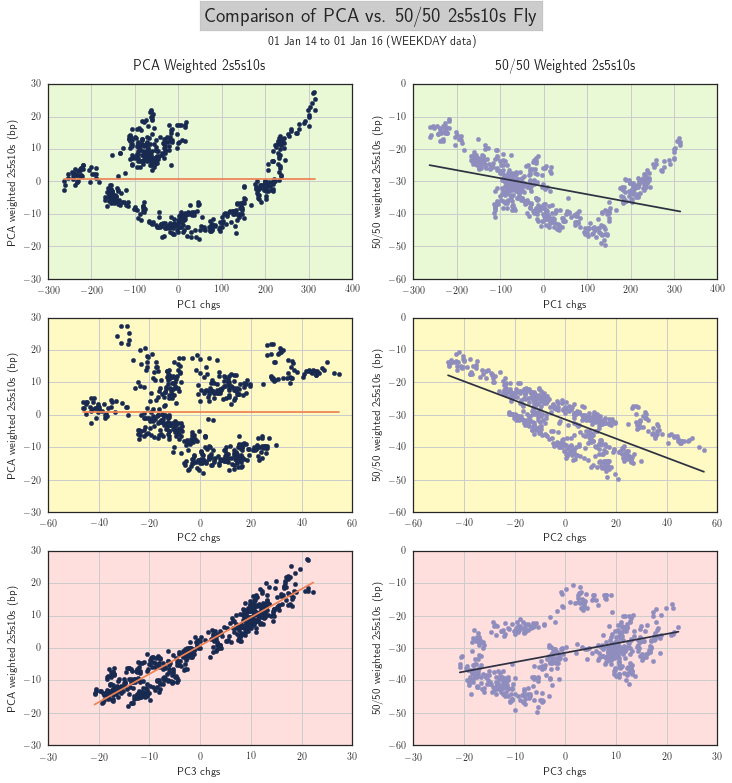

In [90]:
import statsmodels.api as sm
firstDate = data.index[0].strftime("%d %b %y")
lastDate = data.index[-1].strftime("%d %b %y")
pcaFly = flyTrade["PCA "+fly].dropna().values
stdFly = flyTrade["Standard "+fly].dropna().values

across = ["PCA "+fly, "Std "+fly]

down = histFactors.index.values

trades = [pcaFly, stdFly]

colors = ["#ffdede", "#fffac4","#e9f9d6"][::-1]

def pcFlyRegress():
    fig, axes = plt.subplots(3, 2)
    fig.set_size_inches(12,12)
    fig.suptitle("Comparison of PCA vs. 50/50 "+fly+" Fly", fontsize=20,bbox={'facecolor':'black', 'alpha':0.2, 'pad':5})
    fig.text(0.5, 0.94, "%s to %s (%s data)"%(firstDate, lastDate, freq),ha='center', va='center')
    
    fig.subplots_adjust(top=0.89)
    for i in range(len(axes)):
        x = histFactors["PC"+str(i+1)].dropna().values
        y = trades
        plot(axes[i], x, y, i)
    
    axes[0][1].set_title("50/50 Weighted "+fly, y=1.05, fontweight="bold",fontsize=14)
    axes[0][0].set_title("PCA Weighted "+fly, y=1.05, fontweight="bold", fontsize=14)

    plt.show()

def plot(axrow, x, y, i):
    axrow[0].scatter(x, y[0], color='#192A51', marker='o')
    axrow[0].grid()
    fit1 = np.polyfit(x, y[1], 1, full=True)
    axrow[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y[0], 1))(np.unique(x)), color="#EF8354")
    axrow[0].set_ylabel("PCA weighted "+fly+" (bp)")
    axrow[0].set_xlabel("PC"+str(i+1)+" chgs")
    axrow[0].set_axis_bgcolor(colors[i])
    
    axrow[1].scatter(x, y[1], color='#8E8DBE')
    axrow[1].grid()
    fit2 = np.polyfit(x, y[1], 1, full=True)
    axrow[1].plot(np.unique(x), np.poly1d(np.polyfit(x, y[1], 1))(np.unique(x)), color='#2D3142')
    axrow[1].set_ylabel("50/50 weighted "+fly+" (bp)")
    axrow[1].set_xlabel("PC"+str(i+1)+" chgs")
    axrow[1].set_axis_bgcolor(colors[i])


pcFlyRegress()

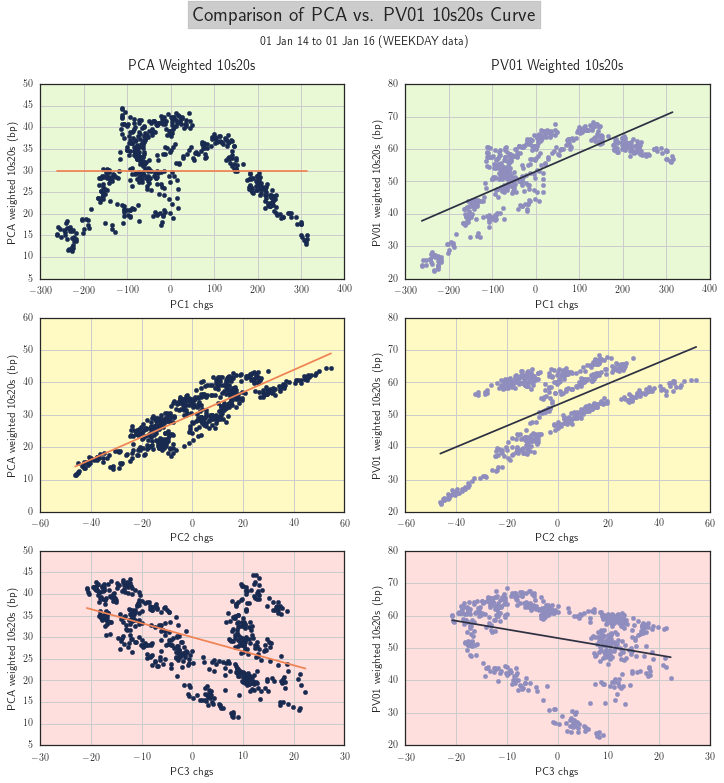

In [91]:
firstDate = data.index[0].strftime("%d %b %y")
lastDate = data.index[-1].strftime("%d %b %y")
pcaCurve = curveTrade["PCA "+curve].dropna().values
stdCurve = curveTrade["Standard "+curve].dropna().values

across = ["PCA "+curve, "Std "+curve]

down = histFactors.index.values

trades = [pcaCurve, stdCurve]

colors = ["#ffdede", "#fffac4","#e9f9d6"][::-1]

def pcCurveRegress():
    fig, axes = plt.subplots(3, 2)
    fig.set_size_inches(12,12)
    fig.suptitle("Comparison of PCA vs. PV01 "+curve+" Curve", fontsize=20,bbox={'facecolor':'black', 'alpha':0.2, 'pad':5})
    fig.text(0.5, 0.94, "%s to %s (%s data)"%(firstDate, lastDate, freq),ha='center', va='center')
    
    fig.subplots_adjust(top=0.89)
    for i in range(len(axes)):
        x = histFactors["PC"+str(i+1)].dropna().values
        y = trades
        plot(axes[i], x, y, i)
    
    axes[0][1].set_title("PV01 Weighted "+curve, y=1.05, fontweight="bold",fontsize=14)
    axes[0][0].set_title("PCA Weighted "+curve, y=1.05, fontweight="bold", fontsize=14)

    plt.show()

def plot(axrow, x, y, i):
    axrow[0].scatter(x, y[0], color='#192A51', marker='o')
    axrow[0].grid()
    fit1 = np.polyfit(x, y[1], 1, full=True)
    axrow[0].plot(np.unique(x), np.poly1d(np.polyfit(x, y[0], 1))(np.unique(x)), color="#EF8354")
    axrow[0].set_ylabel("PCA weighted "+curve+" (bp)")
    axrow[0].set_xlabel("PC"+str(i+1)+" chgs")
    axrow[0].set_axis_bgcolor(colors[i])
    
    axrow[1].scatter(x, y[1], color='#8E8DBE')
    axrow[1].grid()
    fit2 = np.polyfit(x, y[1], 1, full=True)
    axrow[1].plot(np.unique(x), np.poly1d(np.polyfit(x, y[1], 1))(np.unique(x)), color='#2D3142')
    axrow[1].set_ylabel("PV01 weighted "+curve+" (bp)")
    axrow[1].set_xlabel("PC"+str(i+1)+" chgs")
    axrow[1].set_axis_bgcolor(colors[i])

pcCurveRegress()

These charts are obvious as the PCA weights were fit to get this result. However, they are still a pretty visualization of what the PCA hedge really means. It is intended to be ignorant of the move in outright level and slope (PC1 and PC2), and a pure micro RV play on PC3.

If we were to put on the 50/50 fly to trade PC3, we would just be exposed to the outright level of rates and the curve with little exposure to the actual factor.

As for the curve, since the curve is not PC3 hedged, it has exposure to both the a change in steepeness and a change on convexity.

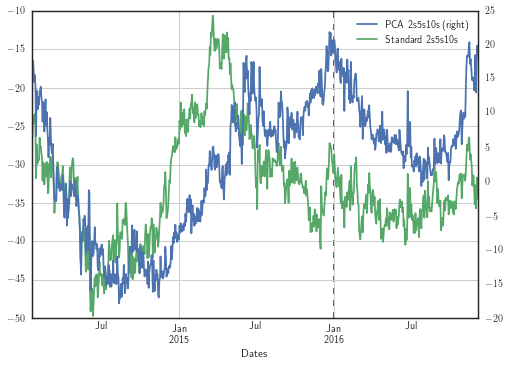

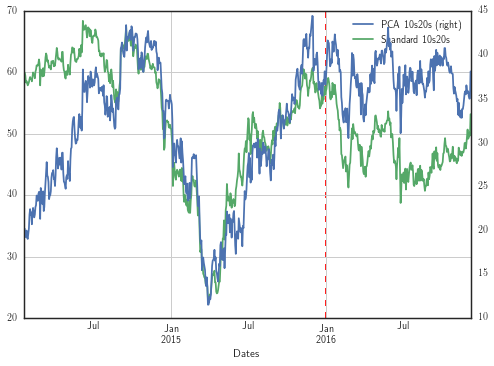

In [92]:
#curvePerf = genTrade(curve, rawData[end:dt.datetime(2016, 12, 30)], evectors)
flyPerf = genTrade(fly, rawData[dt.datetime(2014, 1, 20):dt.datetime(2017, 2, 8)], pca3)[0]
curvePerf = genTrade(curve, rawData[dt.datetime(2014, 1, 20):dt.datetime(2017, 2, 8)], pca3)[0]
end = dt.datetime(2016,1, 1)

ax1 = flyPerf.ix[:, 3:].plot(secondary_y="PCA "+fly) ## rec this
ax1.axvline(end, color='r', zorder=0, ls="dashed")
ax1.grid()

ax2 = curvePerf.ix[:, 2:].plot(secondary_y="PCA "+curve) ## rec this
ax2.axvline(end, color='r', zorder=0, ls="dashed")
ax2.grid()


Looks like these trades would've worked out. 

## Mean Reversion

The fly looks like it mean reverts quite well. Let's try using the ADF test.

In [93]:
import statsmodels.tsa.stattools as ts
print("Fly Residuals \n \t"+str(ts.adfuller(flyResiduals.ix[:,3], 1)))
print("Curve Residuals \n \t"+str(ts.adfuller(curveResiduals.ix[:,2], 1)))
print("Fly Trade\n \t"+str(ts.adfuller(flyTrade.ix[:,3], 1)))
print("Curve Trade \n \t"+str(ts.adfuller(curveTrade.ix[:,2], 1)))

Fly Residuals 
 	(-4.2037580934938017, 0.00064931489573505005, 1, 521, {'10%': -2.5697331315829222, '1%': -3.4429638415440995, '5%': -2.8671034821276349}, 1836.447070953657)
Curve Residuals 
 	(-6.1451064930731887, 7.8013809959463437e-08, 1, 521, {'10%': -2.5697331315829222, '1%': -3.4429638415440995, '5%': -2.8671034821276349}, 1153.3664213218369)
Fly Trade
 	(-2.2266583453359732, 0.19671265655854725, 1, 521, {'10%': -2.5697331315829222, '1%': -3.4429638415440995, '5%': -2.8671034821276349}, 2238.8235282860205)
Curve Trade 
 	(-2.1474189198673961, 0.22587937069661412, 1, 521, {'10%': -2.5697331315829222, '1%': -3.4429638415440995, '5%': -2.8671034821276349}, 1687.7932952869633)


The residuals mean revert quite well, whereas the actual trade time series do not. 

In [94]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(1,len(ts)-1)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

print (hurst(pcaFly))
print (hurst(pcaCurve))

0.170892797288
-0.211910199238


The Hurst exponent is very close to 0 indicating a good possibility of having found a mean reverting time series.

# Ornstein-Uhlenbeck parameter estimation

Let's assume that the fly and curve follow a mean reverting OU process and estimate the model parameters using historical data. We will do another notebook on mean reversion that digs further into the time series later. For now, we just use a simple OLS to estimate the parameters, instead of MLE etc.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                 1.264e+04
Date:                Mon, 19 Dec 2016   Prob (F-statistic):               0.00
Time:                        08:47:37   Log-Likelihood:                -1134.0
No. Observations:                 522   AIC:                             2272.
Df Residuals:                     520   BIC:                             2281.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0051      0.093      0.055      0.9

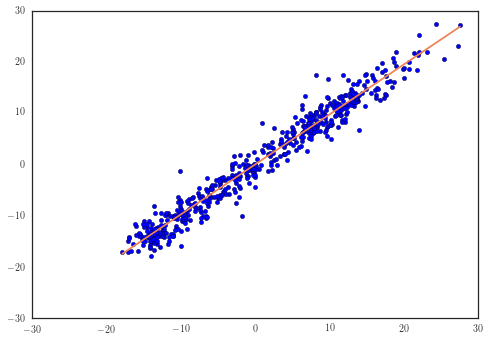

lambda = 0.0219336719934
Mu = 0.236586283697
Sigma = 1.01098666106
Half life = 31.6019670928


In [95]:
Si = pcaFly[:-1]
Sj = pcaFly[1:]


results = sm.OLS(Sj,sm.add_constant(Si)).fit()
print (results.summary())
print (results.params)
xmin, xmax = np.unique(Si).min(), np.unique(Si).max()
plt.scatter(Si, Sj)
X_plot = np.linspace(xmin,xmax,)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0],color="#EF8354")

plt.show()

a, b = results.params[1], results.params[0]
lambFly = -np.log(a)
muFly = b/(1-a)
sigmaFly = np.sqrt(-2*np.log(a)/(1-a**2))

print ("lambda = "+str(lambFly))
print ("Mu = "+str(muFly))
print("Sigma = "+str(sigmaFly))
print("Half life = "+str(np.log(2)/lambFly))

Curve:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 2.228e+04
Date:                Mon, 19 Dec 2016   Prob (F-statistic):               0.00
Time:                        08:47:40   Log-Likelihood:                -844.49
No. Observations:                 522   AIC:                             1693.
Df Residuals:                     520   BIC:                             1701.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.4783      0.205      2.332      0.0

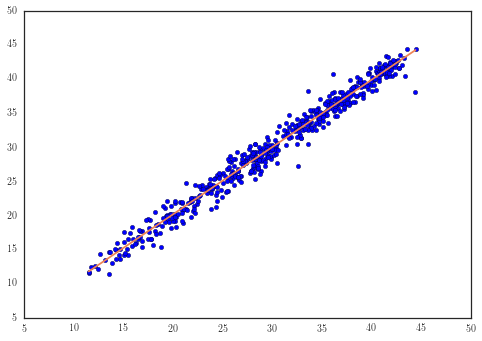

lambda = 0.0145664672337
Mu = 33.0777145842
Sigma = 1.00729201007
Half life = 47.5851261285


In [96]:
Si = pcaCurve[:-1]
Sj = pcaCurve[1:]


results = sm.OLS(Sj,sm.add_constant(Si)).fit()
print (results.summary())
print (results.params)
xmin, xmax = np.unique(Si).min(), np.unique(Si).max()
plt.scatter(Si, Sj)
X_plot = np.linspace(xmin,xmax,)
plt.plot(X_plot, X_plot*results.params[1] + results.params[0],color="#EF8354")

plt.show()

a, b = results.params[1], results.params[0]
lambCrv = -np.log(a)
muCrv = b/(1-a)
sigmaCrv = np.sqrt(-2*np.log(a)/(1-a**2))

print ("lambda = "+str(lambCrv))
print ("Mu = "+str(muCrv))
print("Sigma = "+str(sigmaCrv))
print("Half life = "+str(np.log(2)/lambCrv))

Comment for later: Half life looks really fast.... need to check.

Last Value: 19.285714148
522 766
PCA 2s5s10s   NaN
Name: 2016-12-08 00:00:00, dtype: float64
Last Value: 37.2403322742
522 766
PCA 10s20s   NaN
Name: 2016-12-08 00:00:00, dtype: float64


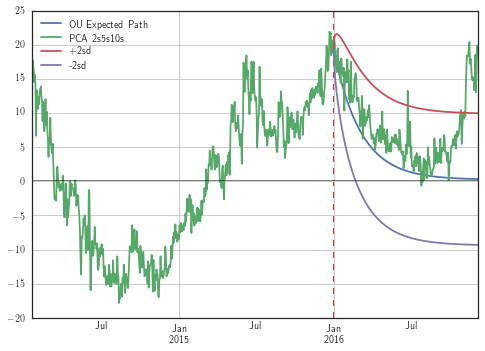

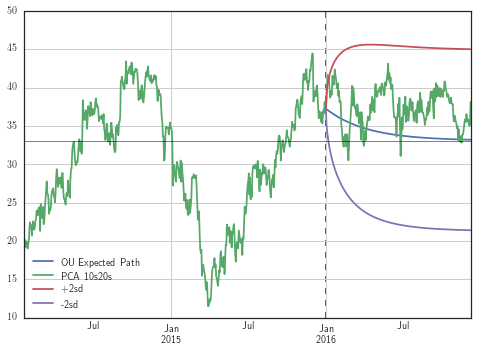

In [97]:
ouModel = pd.DataFrame(index=flyPerf.index.values) 
ouModel = pd.concat([ouModel, flyTrade["PCA "+fly]], axis=1)
ouStart = flyTrade["PCA "+fly].index.values[-1]
ouStart = ouModel["PCA "+fly].last_valid_index()
stIdx = ouModel.index.get_loc(ouStart)
lastIdx = len(ouModel.index)-1
stVal = ouModel.ix[stIdx, 0]
print ("Last Value: "+str(stVal))
print (stIdx, lastIdx)
print (ouModel.ix[lastIdx, :])

globalOU = []
##### NEED TO FIX THE RECURSIVE FUNCTION HERE... WORKS OK BUT NOT SCALABLE.
def ouGen(first,n, mu, lamb, sigma):
    a = np.exp(-lamb)
    b = mu*(1-np.exp(-lamb))
    if n == 0:
        globalOU.append(first)
        return [first]
    else:
        prev = a*ouGen(first, n-1, mu, lamb, sigma)[0]+b
        globalOU.append(prev)
        return [prev] + [a*prev + b]
      
def retOUexp(first, n, mu, lamb, sigma):
    
    ouresult = []
    
    ouGen(first, n, mu, lamb, sigma, ouresult)
    
    return ouresult
    

        
def ouConf(n, lamb, sigma, sd):
    sigmaSq = sigma**2
    ret = [sd*np.sqrt(sigmaSq/2/lamb*(1-np.exp(-2*lamb*i))) for i in range(n+1)]
    return ret

if (stIdx == lastIdx):
    n = 160
    ou2 = np.array(ouConf(n, lambFly, sigmaFly, 2))
    ouExp = ouGen(stVal, n, muFly, lambFly, sigmaFly)
    p2sd = np.array(globalOU) + ou2
    n2sd = np.array(globalOU) - ou2
    p2sd = p2sd.tolist()
    n2sd = n2sd.tolist()
    ouDates = pd.date_range(ouStart, ouStart + dt.timedelta(days=n))
    pSigma = pd.DataFrame(p2sd, index=ouDates, columns = ["+2sd"])
    nSigma = pd.DataFrame(n2sd, index=ouDates, columns = ["-2sd"])
    results = pd.DataFrame(globalOU, index=ouDates, columns=["OU Expected Path"])
    results = pd.concat([results,flyPerf["PCA "+fly], pSigma, nSigma], axis=1)

    
else:
    n = lastIdx - stIdx
    ou2 = np.array(ouConf(n, lambFly, sigmaFly, 2))
    ouExp = ouGen(stVal, n, muFly, lambFly, sigmaFly)
    p2sd = np.array(globalOU) + ou2
    n2sd = np.array(globalOU) - ou2
    p2sd = p2sd.tolist()
    n2sd = n2sd.tolist()
    pSigma = pd.DataFrame(p2sd, index=ouModel.index.values[stIdx:lastIdx+1], columns = ["+2sd"])
    nSigma = pd.DataFrame(n2sd, index=ouModel.index.values[stIdx:lastIdx+1], columns = ["-2sd"])
    results = pd.DataFrame(globalOU, index=ouModel.index.values[stIdx:lastIdx+1], columns=["OU Expected Path"])
    results = pd.concat([results,flyPerf["PCA "+fly], pSigma, nSigma], axis=1)

mean = flyTrade["PCA "+fly].mean()
ax1 = results.plot()
ax1.axhline(muFly, color="black", linewidth=0.5)
ax1.axvline(ouStart, color='r', zorder=0, ls="dashed")
ax1.grid()


globalOU = []
ouModelCrv = pd.DataFrame(index=curvePerf.index.values) 
ouModelCrv = pd.concat([ouModelCrv, curveTrade["PCA "+curve]], axis=1)
ouStart = curveTrade["PCA "+curve].index.values[-1]
ouStart = ouModelCrv["PCA "+curve].last_valid_index()
stIdx = ouModelCrv.index.get_loc(ouStart)
lastIdx = len(ouModelCrv.index)-1
stVal = ouModelCrv.ix[stIdx, 0]
print ("Last Value: "+str(stVal))
print (stIdx, lastIdx)
print (ouModelCrv.ix[lastIdx, :])

if (stIdx == lastIdx):
    n = 160
    ou2 = np.array(ouConf(n, lambCrv, sigmaCrv, 2))
    ouExp = ouGen(stVal, n, muCrv, lambCrv, sigmaCrv)
    p2sd = np.array(globalOU) + ou2
    n2sd = np.array(globalOU) - ou2
    p2sd = p2sd.tolist()
    n2sd = n2sd.tolist()
    ouDates = pd.date_range(ouStart, ouStart + dt.timedelta(days=n))
    pSigma = pd.DataFrame(p2sd, index=ouDates, columns = ["+2sd"])
    nSigma = pd.DataFrame(n2sd, index=ouDates, columns = ["-2sd"])
    results = pd.DataFrame(globalOU, index=ouDates, columns=["OU Expected Path"])
    results = pd.concat([results,curvePerf["PCA "+curve], pSigma, nSigma], axis=1)

    
else:
    n = lastIdx - stIdx
    ou2 = np.array(ouConf(n, lambCrv, sigmaCrv, 2))
    ouExp = ouGen(stVal, n, muCrv, lambCrv, sigmaCrv)
    p2sd = np.array(globalOU) + ou2
    n2sd = np.array(globalOU) - ou2
    p2sd = p2sd.tolist()
    n2sd = n2sd.tolist()
    pSigma = pd.DataFrame(p2sd, index=ouModel.index.values[stIdx:lastIdx+1], columns = ["+2sd"])
    nSigma = pd.DataFrame(n2sd, index=ouModel.index.values[stIdx:lastIdx+1], columns = ["-2sd"])
    results = pd.DataFrame(globalOU, index=ouModel.index.values[stIdx:lastIdx+1], columns=["OU Expected Path"])
    results = pd.concat([results,curvePerf["PCA "+curve], pSigma, nSigma], axis=1)

mean2 = curveTrade["PCA "+curve].mean()
ax2 = results.plot()
ax2.axhline(muCrv, color="black", linewidth=0.5)
ax2.axvline(ouStart, color='r', zorder=0, ls="dashed")
ax2.grid()

